# Classify Polyps for Colon Cancer

## Import Libraries

In [2]:
import os
import csv
import cv2
import sys
import collections
import pandas as pd
import itertools
import numpy as np
import seaborn as sns
from tqdm import tqdm

from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.preprocessing import LabelEncoder

import xml.etree.ElementTree as ET

In [3]:
%matplotlib inline

## Helper Functions

In [4]:
def get_filepaths(basepath, file_type):
    files = []
    filenames = []
    for filename in os.listdir(basepath):
        if filename.endswith(file_type):
            filepath = os.path.join(basepath, filename)
            files.append(filepath)
        filenames.append(filename)
    return files, filenames

def read_img(img_path):
    # (height, width, 3)
    image = cv2.imread(img_path)
    # (1, height, width, 3)
    image = np.expand_dims(image, axis=0)
#     print("This image is:", type(image), "with dimensions:", image.shape)
    return image

def get_xml_label_names(xml_files):
    label_names = []
    for xml_file in tqdm(xml_files):
#         print("xml_file =", xml_file)
        train_y_tree = ET.parse(xml_file)
        train_y_root = train_y_tree.getroot()
        if train_y_root.find("object") != None:
            train_y_object = train_y_root.find("object")
            train_y_polyp_name = train_y_object.find("name").text
        else:
            train_y_polyp_name = "Not Specified"
        label_names.append(train_y_polyp_name)
    return label_names

def get_xml_boundboxes(xml_files):
    bound_boxes = []
    for xml_file in tqdm(xml_files):
        train_y_tree = ET.parse(xml_file)
        train_y_root = train_y_tree.getroot()
        if train_y_root.find("object") != None:
            train_y_object = train_y_root.find("object")
            train_y_bndbox = train_y_object.find("bndbox")
            train_y_bndbox_xmin = train_y_bndbox.find("xmin").text
            train_y_bndbox_ymin = train_y_bndbox.find("ymin").text
            train_y_bndbox_xmax = train_y_bndbox.find("xmax").text
            train_y_bndbox_ymax = train_y_bndbox.find("ymax").text
            bound_box_tuple = (train_y_bndbox_xmin, train_y_bndbox_ymin, train_y_bndbox_xmax, train_y_bndbox_ymax)
        else:
            bound_box_tuple = False
        bound_boxes.append(
            bound_box_tuple
        )
    return bound_boxes

def create_image_label_groups(image_paths, image_labels, batch_size=32):
    # Divide image paths and image labels into groups of BATCH_SIZE
    image_groups = list()
    label_groups = list()
    
    for idx in range(0, len(image_paths), batch_size):
        for index in range(idx, idx + batch_size):
            image_groups.append(image_paths[index % len(image_paths)])
            
    for idx in range(0, len(image_labels), batch_size):
        for index in range(idx, idx + batch_size):
            label_groups.append(image_labels[index % len(image_labels)])
    
# normalizes image pixel values betwen -0.5 and 0.5
def normalize_images(images):
    norm_images = []
    for image in tqdm(images):
        norm_img = (image/255.0) - 0.5
        norm_images.append(norm_img)
    return norm_images

def normalize_image(image):
    norm_img = (image/255.0) - 0.5
    return norm_img

# def resize_image(image, size):
#     resized_image = cv2.resize(image, (size, size))
#     return resize_image
    
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def get_images(img_files, prep = "gray"):
    images = []
    for img_file in tqdm(img_files):
        image = read_img(img_file)
#         if prep == "gray":
#             image = grayscale(image)
#             image = normalize_image(image)
#         elif prep == "gaussian":
#             image = gaussian_blur(image, 9)
#             image = normalize_image(image)
#         else:
#             image = grayscale(image)
#             image = gaussian_blur(image, 9)
#             image = normalize_image(image)
        images.append(image)
    return images



def change_extension(img_file, file_type):
    p = Path(img_file)
    return p.rename(p.with_suffix(file_type))
    



# loads image from filepath using opencv
def get_image(basepath, filepath):
    # read images
    source_path = filepath
    # extract filename from filepath using split and check platform
    if sys.platform == 'win32':
        filename = source_path.split("\\")[-1]
    elif sys.platform == 'linux' or sys.platform == 'darwin':
        filename = source_path.split("/")[-1]
    # add filename to end of path to PolypSet dir, so platform isn't an issue
    img_path_on_fs = basepath + filename
    # load image using opencv
    image = cv2.imread(img_path_on_fs)
    return image

## Load Training Images & Labels

In [5]:
# Extract image along with its associated boundbox
train_X_images = []
train_y_polyp_bndbox = []

## Get Polyp Names for Training Y Set

Annotation xml reference from one of the training y label files. We parse this file for polyp name and bounding box data

~~~xml
<annotation>
    <folder>16</folder>
    <filename>11.jpg</filename>
    <path>/scratch/mfathan/Thesis/Dataset/Extracted/80_Videos_Frames/pretest/16/11.jpg</path>
    <source>
        <database>Unknown</database>
    </source>
    <size>
        <width>544</width>
        <height>448</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>hyperplastic</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <difficult>0</difficult>
        <bndbox>
            <xmin>285</xmin>
            <ymin> 282</ymin>
            <xmax> 389</xmax>
            <ymax> 370</ymax>
        </bndbox>
    </object>
</annotation>
~~~

In [6]:
train_y_basepath = "PolypsSet/train2019/Annotation"
file_type = ".xml"
train_y_filepaths, train_y_filenames = get_filepaths(train_y_basepath, file_type)

In [7]:
train_y_polyp_names = get_xml_label_names(train_y_filepaths)

100%|████████████████████████████████████████████████████████████| 28773/28773 [02:30<00:00, 191.63it/s]


In [8]:
print(len(train_y_filepaths))
print(train_y_filepaths[0])
print(train_y_filenames[0])

28773
PolypsSet/train2019/Annotation\1.xml
1.xml


## Get Images for Training X & Training Y Set

In [9]:
train_X_basepath = "PolypsSet/train2019/Image"
file_type = ".jpg"
train_X_filepaths, train_X_filenames = get_filepaths(train_X_basepath, file_type)


In [10]:
print(len(train_X_filepaths))
print(train_X_filepaths[1])
print(train_X_filenames[1])

28773
PolypsSet/train2019/Image\10.jpg
10.jpg


In [11]:
# train_X_images = get_images(train_X_filepaths, train_y_polyp_names): 4:39PM - 
train_X_images = get_images(train_X_filepaths, prep="gray")

100%|█████████████████████████████████████████████████████████████| 28773/28773 [09:52<00:00, 48.56it/s]


In [14]:
print("len train_X_images = ", len(train_X_images))

len train_X_images =  28773


In [ ]:
plt.suptitle(train_X_filepaths[0])
plt.imshow(train_X_images[0])

In [16]:
train_X_images[0]

array([[[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        ...,

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]]], dtype=uint8)

In [17]:
train_X_images[0].shape

(1, 288, 384, 3)

In [18]:
train_X_images

[array([[[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
 
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
 
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
 
         ...,
 
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
 
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
 
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]]], dtype=uint8), array([[[[21, 21, 21],
          [21, 21, 21],
          [21, 21, 21],
          ...,
          [21, 21, 2

In [ ]:
# train_X_images_scaled = normalize_images(train_X_images)

In [ ]:
# X_train_images = np.array(train_X_images)

In [ ]:
# X_train_images

In [19]:
label_enc = LabelEncoder()

In [20]:
train_y_polyp_names_enc = label_enc.fit_transform(train_y_polyp_names)

In [21]:
train_y_polyp_names_enc

array([1, 2, 1, ..., 1, 2, 1], dtype=int64)

c:\users\james\anaconda3\envs\nlp-asr\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


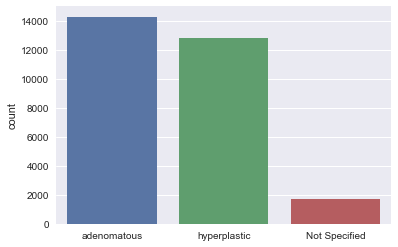

In [22]:
sns.countplot(train_y_polyp_names)

In [23]:
polyp_counter = collections.Counter(train_y_polyp_names)

In [24]:
polyp_counter

Counter({'Not Specified': 1725, 'adenomatous': 14269, 'hyperplastic': 12779})

## Build Fully Convolutional Network

In [31]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Input, Flatten, Dense, Activation, Lambda, Cropping2D, Dropout, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import GlobalMaxPooling2D

In [32]:
len_classes=3
dropout_rate=0.2

# model = Sequential()
# model.add(Input(shape=(1, None, None, 3)))
# model.add(Conv2D(filters=64, kernel_size=3, strides=1))
# model.add(Dropout(dropout_rate))
# model.add(BatchNormalization())
# model.add(Activation("relu"))
# model.add(Conv2D(filters=64, kernel_size=3, strides=1))
# model.add(Dropout(dropout_rate))
# model.add(BatchNormalization())
# model.add(Activation("relu"))
# model.add(Conv2D(filters=len_classes, kernel_size=1, strides=1))
# model.add(Dropout(dropout_rate))
# model.add(BatchNormalization())
# model.add(GlobalMaxPooling2D())
# model.add(Activation("softmax"))


# def FCN_model(len_classes=3, dropout_rate = 0.2):
input = keras.layers.Input(shape=(None, None, 3))
    
    # Fully convolution layer 1
x = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1)(input)
x = keras.layers.Dropout(dropout_rate)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

#     # Fully convolution layer 2
x = keras.layers.Conv2D(filters=64, kernel_size=3, strides=1)(input)
x = keras.layers.Dropout(dropout_rate)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
    
#     # Fully Connected Convolution layer 1
x = keras.layers.Conv2D(filters=len_classes, kernel_size=1, strides=1)(x)
x = keras.layers.Dropout(dropout_rate)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.GlobalMaxPooling2D()(x)
predictions = keras.layers.Activation("softmax")(x)
    
model = keras.Model(inputs=input, outputs=predictions)
print(model.summary())
# print(f"Total number of layers: {len(model.layers)}")
    
#     return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 64)    1792      
_________________________________________________________________
dropout_2 (Dropout)          (None, None, None, 64)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, None, None, 64)    256       
_________________________________________________________________
activation_2 (Activation)    (None, None, None, 64)    0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 3)     195       
_________________________________________________________________
dropout_3 (Dropout)          (None, None, None, 3)     0         
__________

In [ ]:
# model = FCN_model(len_classes=3, dropout_rate=0.2)

## Train FCN Model

In [33]:
X_train = np.array(train_X_images)
y_train = np.array(train_y_polyp_names_enc)

ValueError: could not broadcast input array from shape (288,384,3) into shape (1)

In [ ]:
X_train.shape

In [ ]:
X_train_copy = X_train.copy()

In [ ]:
X_train_copy.reshape(-1, 288,384,3)

In [ ]:
X_train[0].shape

In [34]:
model.compile(loss="categorical_crossentropy", 
              optimizer="adam", metrics=["accuracy"])

model.fit(train_X_images, train_y_polyp_names_enc, validation_split=0.2, shuffle=True, epochs=2)

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 1 array(s), but instead got the following list of 28773 arrays: [array([[[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
   ...

We have more cancerous polyps (adenomatous) in our training data set compared to non cancerous polyps (hyperplastic).

In [ ]:
model.save("fcn_model.h5")

## Resources

- [Three Ways of Storing and Accessing Lots of Images in Python](https://realpython.com/storing-images-in-python/#reading-a-single-image)